In [28]:
import numpy as np
from scipy.signal.windows import tukey
import torch

def sine(phi):
    return torch.sin(2 * torch.pi * phi)

sr = 2**13

torch.manual_seed(0)

def syn_texture(log2_density=6.0, sign=1):
    duration = 2
    
    fmin = 2**8
    fmax = 2**9
    n_events = 128
    threshold_db = -10

    event_length = torch.tensor(1/4 * sr).type(torch.int64)

    gamma = torch.tensor(2.0, requires_grad=True)

    # density
    log2_density = torch.tensor(float(log2_density), requires_grad=True)
    # sign
    # sign = -1 #[-1, 1]

    event_ids = torch.tensor(np.arange(n_events)).type(torch.int64)
    density = torch.pow(2.0, log2_density)
    amplitudes_db = event_ids * threshold_db / density
    amplitudes = torch.nn.functional.softmax(amplitudes_db, dim=-1)

    onsets = torch.floor(torch.rand(n_events) * (duration*sr - event_length))
    onsets = onsets.type(torch.int64)
    log2_fmin = torch.log2(torch.tensor(fmin))
    log2_fmax = torch.log2(torch.tensor(fmax))
    log2_frequencies = log2_fmin + torch.rand(n_events) * (log2_fmax-log2_fmin)
    frequencies = torch.pow(2.0, log2_frequencies)

    X = torch.zeros(duration*sr, n_events)

    time = torch.arange(0, event_length/sr, 1/sr)
    #envelope = core.gauss_window(event_length, std=torch.tensor(0.1)*event_length)
    envelope = torch.tensor(tukey(event_length))

    patch_zip = zip(event_ids, onsets, amplitudes, frequencies)
    for event_id, onset, amplitude, frequency in patch_zip:
        chirp = sine(frequency / (gamma*np.log(2)) * (2 ** (sign*gamma*time) - 1))
        offset = onset + event_length
        X[onset:offset, event_id] = chirp * amplitude * envelope


    x = X.sum(axis=-1)
    window = torch.tensor(tukey(duration*sr))
    y = x*window
    y = y/y.norm()
    return y

In [32]:
import scipy.io.wavfile
import os

for file_name in os.listdir('audio/texture'):
    file = 'audio/texture/' + file_name
    if os.path.isfile(file):
        os.remove(file)

for density in np.arange(1, 8):
    y = syn_texture(density, -1)
    scipy.io.wavfile.write('audio/texture/-'+str(density)+'.wav', sr, y.detach().numpy())
    y = syn_texture(density)
    scipy.io.wavfile.write('audio/texture/'+str(density)+'.wav', sr, y.detach().numpy())

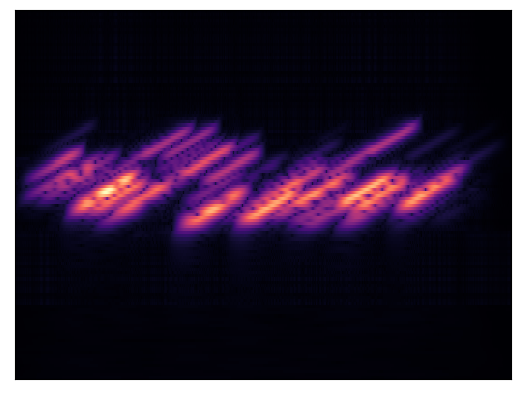

In [30]:
import librosa
from librosa.display import specshow

cqt_kwargs = {"sr": sr, "fmin": 2**6, "bins_per_octave": 24, "hop_length": 32}
CQT = librosa.cqt(y.detach().numpy(), n_bins=120, **cqt_kwargs)
specshow((np.abs(CQT)**0.33), **cqt_kwargs)

In [31]:
from IPython.display import Audio
Audio(data=y.detach().numpy(), rate=sr)